In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
from plotnine import *
from tqdm import tqdm
from joblib import Parallel, delayed # for parallel processing
import statsmodels.formula.api as smf

## Data Generating Process

In [4]:
def dgp(n=2000, p=10):
        
    Xmat = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=n).astype('float32')

    T = np.random.binomial(1, 0.5, n).astype('int8')

    col_list = ['X' + str(x) for x in range(1,(p+1))]

    df = pd.DataFrame(Xmat, columns = col_list)
    
    # functional form of the covariates
    B = 225 + 50*df['X1'] + 5*df['X2'] + 20*(df['X3']-0.5) + 10*df['X4'] + 5*df['X5']

    # constant ate
    tau = 5 
    
    Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
        
    df['T'] = T
    df['Y'] = Y

    return df

## Difference-in-Means Estimator

In [35]:
data = dgp(n=2000, p=10)
#Correlations
# print(data[['Y','X1','X2','X3','X4','X5','T']].corr()['Y'])
# print(data['Y'].describe())

ols = smf.ols('Y ~ T', data = data).fit(cov_type='HC1',use_t=True)

ols.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,217.1078,1.818,119.398,0.000,213.542,220.674
T,-0.6416,2.632,-0.244,0.807,-5.804,4.521


## Run the Experiment Many Times

In [54]:
def experiment(**kwargs):
    dct = {}
    
    n = kwargs['n']
    p = kwargs['p']
   
    df = dgp(n,p)
    
    #Difference-in-means
    mu_treated = np.mean(df.query('T==1')['Y'])
    mu_control = np.mean(df.query('T==0')['Y'])
    
    dct['DIM'] = mu_treated - mu_control

    return dct
    

In [64]:
def plot_experiment(results):
    
    results_long = pd.melt(results, value_vars=results.columns.tolist() )  
    mu = 5
    p = (ggplot(results_long, aes(x='value') ) + 
     geom_density(size=1, color='salmon')+
     geom_vline(xintercept=mu, colour='black', linetype='dashed' ) + 
     annotate("text", x=mu, y=.1, label="True Mean", size=15)+
     labs(color='Method')  +
     xlab('Estimate') +
     theme(figure_size=(10, 8))
    )
    
    return p

In [65]:
%%time
tqdm._instances.clear() 
sim = 10000

results = Parallel(n_jobs=8)(delayed(experiment)(n=2000, p=10)\
                                    for _ in tqdm(range(sim)) )

results_df = pd.DataFrame(results)

plot = plot_experiment(results_df) 

100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 3322.56it/s]


CPU times: user 882 ms, sys: 57.3 ms, total: 939 ms
Wall time: 3.36 s


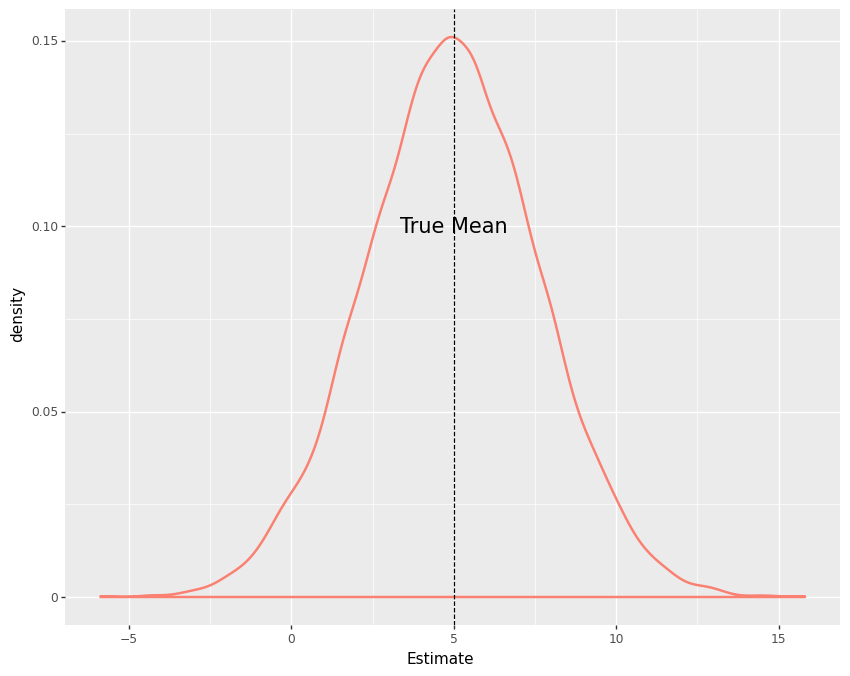

<ggplot: (388435962)>

In [66]:
plot

In [67]:
ggplot.save(plot,"experiment")

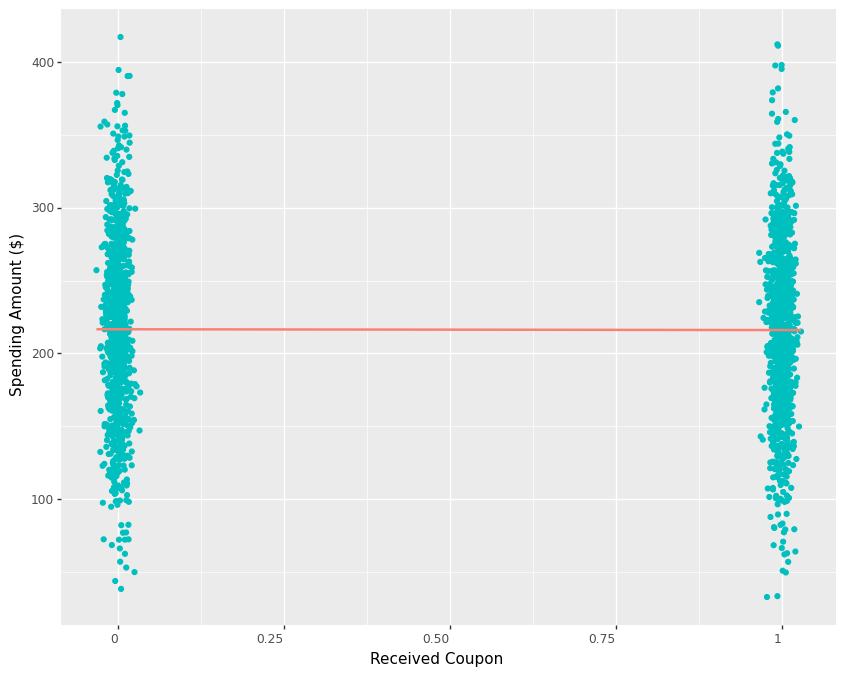

<ggplot: (690138956)>

In [12]:
data['Tplot'] = data['T'] + np.random.normal(0, 0.01, size=len(data["Y"]))

p0 = (ggplot(data, aes(x='Tplot', y='Y'))+
 geom_point(color='c')+
 ylab("Spending Amount ($)") + 
 xlab("Received Coupon")+
 geom_smooth(method='lm',se=False, color="salmon")+
 theme(figure_size=(10, 8)) +
  theme(axis_text_x = element_text(angle = 0, hjust = 1))
)
p0

In [51]:
ggplot.save(p0,"p0")

## Difference-in-Means with Larger Sample

In [60]:
data = dgp(n=10000, p=10)

ols = smf.ols('Y ~ T', data = data).fit(cov_type='HC1',use_t=True)

ols.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,214.9127,0.852,252.245,0.000,213.243,216.583
T,4.3861,1.227,3.576,0.000,1.982,6.791


## Regression Adjustment

In [63]:
data = dgp(n=2000, p=10)

ols = smf.ols('Y ~ T+' + ('+').join(data.columns.tolist()[0:10]),
                 data = data).fit(cov_type='HC1',use_t=True)

ols.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,214.6644,0.822,261.302,0.000,213.053,216.276
T,4.3032,1.146,3.756,0.000,2.056,6.550
X1,50.2190,0.581,86.416,0.000,49.079,51.359
X2,5.0636,0.585,8.661,0.000,3.917,6.210
X3,20.2852,0.597,33.994,0.000,19.115,21.455
X4,10.3428,0.570,18.132,0.000,9.224,11.461
X5,6.2164,0.539,11.528,0.000,5.159,7.274
X6,-0.3549,0.565,-0.628,0.530,-1.463,0.753
X7,-0.1838,0.558,-0.330,0.742,-1.278,0.910
X8,-0.2131,0.566,-0.376,0.707,-1.324,0.898


## Partialling Out

In [97]:
model_t = smf.ols('T ~ ' + ('+').join(data.columns.tolist()[0:10]), data=data).fit(cov_type='HC1',use_t=True)
model_y = smf.ols('Y ~ ' + ('+').join(data.columns.tolist()[0:10]), data=data).fit(cov_type='HC1',use_t=True)

residuals = pd.DataFrame(dict(res_y=model_y.resid, res_t=model_t.resid))

model_res = smf.ols('res_y ~ res_t', data=residuals).fit()

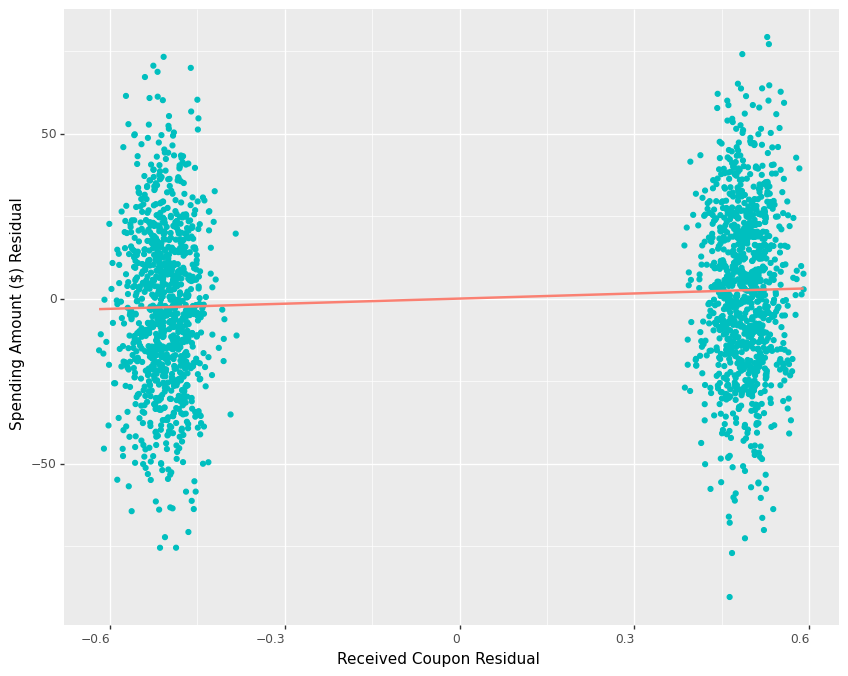

<ggplot: (732434411)>

In [104]:
# residuals['Tplot'] = data['Tplot']

p1=(ggplot(residuals, aes(x='res_t', y='res_y'))+
 geom_point(color='c') + 
 ylab("Spending Amount ($) Residual") +
 xlab("Received Coupon Residual") +
  geom_smooth(method='lm',se=False, color="salmon")+
 theme(figure_size=(10, 8)) +
  theme(axis_text_x = element_text(angle = 0, hjust = 1))
)

p1

In [105]:
ggplot.save(p1,"p1")

In [68]:
print("Spending Amount Variance:", round(np.var(data["Y"]),2))
print("Spending Amount Residual Variance:", round(np.var(residuals["res_y"]),2))

Spending Amount Variance: 3634.35
Spending Amount Residual Variance: 653.95


In [65]:
model_res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.79e-14,0.569,-1.19e-13,1.000,-1.116,1.116
res_t,5.4000,1.142,4.730,0.000,3.161,7.639
